In [1]:
# Used to display all the matplotlib graphs inside the notebook
%matplotlib inline 

# Hiding the warnings
import warnings
warnings.filterwarnings('ignore')

# Importing all the necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import KNNWithMeans
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import Reader

In [3]:
sns.set() # Setting the default seaborn style for all the plots

## 1) Reading the data 

In [4]:
data = pd.read_csv('ratings_Electronics.csv',header=None) # Storing the given data into a data frame called as "data"

# Exploratory Data Analysis

## 2)  Number of records, structure of the file, number of attributes

In [5]:
data = data.rename(columns={0: "user_id", 1: "product_id",2:'ratings',3:'timestamp'})
data.head()

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [6]:
data.shape # The data has got 195 rows and 24 columns

(7824482, 4)

In [7]:
data.head() # Checking the head of the data frame

,user_id,product_id,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [8]:
# Checking for duplicates and removing the duplicates

print('The shape before removing the duplicates from the data set is :',data.shape)
data = data.drop_duplicates()
print('The shape after removing the duplicates from the data set is :',data.shape)

The shape before removing the duplicates from the data set is : (7824482, 4)
The shape after removing the duplicates from the data set is : (7824482, 4)


In [9]:
data.info() # Checking for the data type of each of the variables and the number of non-null values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7824482 entries, 0 to 7824481
Data columns (total 4 columns):
 #   Column      Dtype  
---  ------      -----  
 0   user_id     object 
 1   product_id  object 
 2   ratings     float64
 3   timestamp   int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 298.5+ MB


In [10]:
data.nunique() # Getting a count of number of unique values in each column so as to identify the continuous and discrete variables

user_id       4201696
product_id     476002
ratings             5
timestamp        5489
dtype: int64

In [11]:
data = data.drop('timestamp', axis=1) # Dropping the 'timestamp' column as it will not play a major role in prediction

In [12]:
data.shape # Checking the shape of the data after removing the 'timestamp' column

(7824482, 3)

In [13]:
data.head() # Glimpse of the data frame after removing the 'timestamp' column

,user_id,product_id,ratings
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Rating is a discrete column with values ranging from 1-5

## 3) The five point summary of 'ratings'

In [14]:
data.describe()

,ratings
count,7.824482e+06
mean,4.012337e+00
std,1.380910e+00
min,1.000000e+00
25%,3.000000e+00
50%,5.000000e+00
75%,5.000000e+00
max,5.000000e+00


## 4) Observing the distribution of the 'ratings'

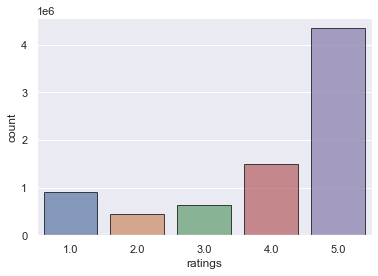

In [15]:
sns.countplot(data['ratings'],edgecolor = 'black', alpha = 0.7)

In [16]:
grouped_data = data.groupby('ratings').size()
print(grouped_data)

ratings
1.0     901765
2.0     456322
3.0     633073
4.0    1485781
5.0    4347541
dtype: int64


### Many of the customers have given he rating as 5 for the products purchased.

In [17]:
from scipy import stats
print('The skewness of "ratings" is :',stats.skew(data['ratings']))

The skewness of "ratings" is : -1.2053969554814676


### - We can see that the data is skewed more towards the left.

## 5) Checking for null values in each of the columns

In [18]:
data.isnull().sum()

user_id       0
product_id    0
ratings       0
dtype: int64

### -There are no null values present in the data set

## 6) Taking the subset of the dataset to make it less sparse/ denser (keeping users who have given 80 or more ratings)

In [19]:
# Grouping the data by 'product_id' to get the count of ratings for each of the products
group = pd.DataFrame(data.groupby('product_id')['ratings'].count())

# Checking for the shape of the grouped object
group.shape

(476002, 1)

In [20]:
group.head() # Checking the top 5 rows of the 'group' dataframe

,ratings
product_id,
0132793040,1
0321732944,1
0439886341,3
0511189877,6
0528881469,27


In [21]:
# Getting the product_ids that have more equal to or more than 80 ratings 
group = group[group['ratings']>=90].sort_values(by='ratings',ascending=False)
group.head()

,ratings
product_id,
B0074BW614,18244
B00DR0PDNE,16454
B007WTAJTO,14172
B0019EHU8G,12285
B006GWO5WK,12226


In [22]:
# Storing all the product ids that have 80 or mroe ratings into a list
product_id = group.index.to_list()
product_id

['B0074BW614',
 'B00DR0PDNE',
 'B007WTAJTO',
 'B0019EHU8G',
 'B006GWO5WK',
 'B003ELYQGG',
 'B003ES5ZUU',
 'B007R5YDYA',
 'B00622AG6S',
 'B0002L5R78',
 'B008OHNZI0',
 'B003LR7ME6',
 'B000LRMS66',
 'B009SYZ8OC',
 'B00BGA9WK2',
 'B004QK7HI8',
 'B009A5204K',
 'B00BGGDVOO',
 'B0098F5W0Q',
 'B002MAPRYU',
 'B002WE6D44',
 'B005HMKKH4',
 'B0012S4APK',
 'B0052YFYFK',
 'B0001FTVEK',
 'B0044YU60M',
 'B00316263Y',
 'B000I68BD4',
 'B006ZP8UOW',
 'B0041Q38NU',
 'B005DOK8NW',
 'B002V88HFE',
 'B0027VT6V4',
 'B000S5Q9CA',
 'B009LL9VDG',
 'B003DZ165W',
 'B005FYNSPK',
 'B004GF8TIK',
 'B0015AARJI',
 'B001XURP7W',
 'B000VX6XL6',
 'B000BQ7GW8',
 'B0053NBLFW',
 'B007IV7KRU',
 'B0087NZ31S',
 'B004G6002M',
 'B005DKZTMG',
 'B0088LYCZC',
 'B007B31IAK',
 'B005X1Y7I2',
 'B000QUUFRW',
 'B004XC6GJ0',
 'B004OB0EBQ',
 'B003ZUIHY8',
 'B006OBGEHW',
 'B0057OCDQS',
 'B009USAJCC',
 'B0062IPIPQ',
 'B00BT7RAPG',
 'B00825BZUY',
 'B0038W0K2K',
 'B008AST7R6',
 'B006W8U2MU',
 'B007I5JT4S',
 'B007P4VOWC',
 'B004HHICKC',
 'B002QEBM

In [23]:
# Filtering the data set so that each product has got 80 or more ratings
electronics_data = data[data['product_id'].isin(product_id)]
electronics_data.head()

,user_id,product_id,ratings
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


## 7) Saving the dataframe as a pickle file so that the data can be loaded quickly and used in the models

In [24]:
electronics_data.to_pickle('electronics_data.pickle')

In [25]:
electronics_data = pd.read_pickle('electronics_data.pickle')
electronics_data.head()

,user_id,product_id,ratings
183,A1BKC6B7YHYTVV,0972683275,4.0
184,AWVFSIB42LHKJ,0972683275,4.0
185,A36MQBNADRH8YY,0972683275,5.0
186,A3SRXMPLAEZ6DP,0972683275,4.0
187,A20XXTXWF2TCPY,0972683275,5.0


In [26]:
electronics_data.shape

(4617820, 3)

## -The data has been processed and can be used in the models. 

# --------------------------------------------------------------------------------------------------------------

## 8) Popularity Recommender Model

In [27]:
# Grouping the elcetronics_data by 'product_id' and getting the mean of ratings for each product
group = pd.DataFrame(electronics_data.groupby('product_id')['ratings'].mean())
print(group.head())

# Grouping the elcetronics_data by 'product_id' and getting the count of ratings for each product
group['count_of_ratings'] = pd.DataFrame(electronics_data.groupby('product_id')['ratings'].count())
print(group.head())

             ratings
product_id          
0972683275  4.470980
1400501466  3.560000
1400501776  3.884892
1400532620  3.684211
1400532655  3.727273
             ratings  count_of_ratings
product_id                            
0972683275  4.470980              1051
1400501466  3.560000               250
1400501776  3.884892               139
1400532620  3.684211               171
1400532655  3.727273               484


In [28]:
group = group.sort_values(by=['ratings','count_of_ratings'],ascending=False)
group

,ratings,count_of_ratings
product_id,,
B0043ZLFXE,4.955556,90
B00GMRCAC6,4.951872,187
B008I6RVZU,4.951456,103
B00CG70K78,4.949367,237
B000053HC5,4.945783,166
...,...,...
B000FMJLQC,1.633094,278
B0084JXKLA,1.593333,150
B002ZUI68G,1.588850,287


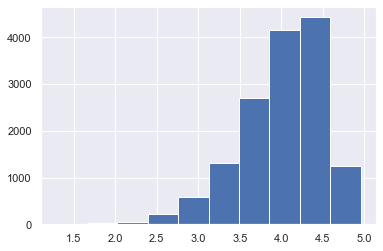

In [29]:
# Plot of mean ratings
group['ratings'].hist()

## 9)  Collaborative Filtering Model

In [30]:
# Creating a smaller subset (30%) of the data due to memory constraints
data = electronics_data.sample(frac=0.4)

In [31]:
data.head()

,user_id,product_id,ratings
3427360,A3CTFWO6WOJZ7G,B003LR7ME6,5.0
7188294,AHZC8CINGFSSZ,B00BXAGSRU,4.0
1998769,A3N4VTNFPMTHEF,B001F7HLRC,5.0
4518452,A19HKRB4LU5YR,B004W2JKWG,4.0
1936410,AFWC7EIGIR181,B001DNGCN2,5.0


In [32]:
# Providing the rating scale (1-5) to the 'Reader' function
reader = Reader(rating_scale=(1, 5)) 
e_data = Dataset.load_from_df(data,reader)

# Splitting the data randomly into trainset and testset
trainset, testset = train_test_split(e_data, test_size=.20,random_state=14)

In [33]:
# Collaborative Filtering model
algorithm = KNNWithMeans(k=5, sim_options={'name': 'pearson_baseline', 'user_based': False})
print(algorithm)
algorithm.fit(trainset) 

# Making the predictions
predictions = algorithm.test(testset)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.


In [34]:
predictions

[Prediction(uid='A3UYKOJKVNYKOP', iid='B007JF85VU', r_ui=3.0, est=4.080979791595328, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A15OLEYIU6H3CA', iid='B001XURP7W', r_ui=5.0, est=4.340116279069767, details={'actual_k': 1, 'was_impossible': False}),
 Prediction(uid='A32KF2T2NYGNJN', iid='B00BGA9WK2', r_ui=5.0, est=4.091289782244556, details={'actual_k': 0, 'was_impossible': False}),
 Prediction(uid='ADZ6MMQPPTDKI', iid='B0019EHU8G', r_ui=5.0, est=4.080979791595328, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A14OJQ5MO8LD0R', iid='B0038FHHHS', r_ui=5.0, est=4.080979791595328, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A5MTSE11L4L27', iid='B0033BU0F8', r_ui=5.0, est=4.080979791595328, details={'was_impossible': True, 'reason': 'User and/or item is unknown.'}),
 Prediction(uid='A4FYHPIDPNEZ9', iid='B00DR0PDNE', r_ui=1.0, est=4.080979791595328

In [35]:
# Evaluating the model

print('The RMSE is: ',accuracy.rmse(predictions, verbose=True))

RMSE: 1.3306
The RMSE is:  1.330630413437883


In [36]:
electronics_data.shape

(4617820, 3)

In [37]:
subset_data = electronics_data.head(100000)

# Creating a pivot table containing the user and the product information with ratings
pivot_of_ratings = subset_data.pivot_table(values='ratings', index='user_id', columns='product_id', fill_value=0)
pivot_of_ratings.head()

product_id,0972683275,1400501466,1400501776,1400532620,1400532655,140053271X,1400599997,1400698987,7214047977,8862935293,...,B00006IRS3,B00006IS4X,B00006IW1X,B00006J07O,B00006JILC,B00006JILW,B00006JKXN,B00006JN3G,B00006JPA1,B00006JPDI
user_id,,,,,,,,,,,,,,,,,,,,,
A00570163ATHRHPDG3GKN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00625243BI8W1SSZNLMD,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A00995931BE16NG4F52QC,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A01035471LBTPFWCOKAU2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A014623426J5CM7M12MBW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Taking the transpose of the pivot table created in the above step
ratings_matrix = pivot_of_ratings.T
ratings_matrix.head()

user_id,A00570163ATHRHPDG3GKN,A00625243BI8W1SSZNLMD,A00995931BE16NG4F52QC,A01035471LBTPFWCOKAU2,A014623426J5CM7M12MBW,A01852072Z7B68UHLI5UG,A02459613IS599WTHNWWS,A02850745KLGY02ZALLI,A0293130VTX2ZXA70JQS,A030530627MK66BD8V4LN,...,AZZNHVT9AH73R,AZZNK89PXD006,AZZOFVMQC0BJG,AZZOHSQB8494S,AZZP8BC9WE0N8,AZZUBI2MEAHI9,AZZUQYE2C1LNI,AZZX23UGJGKTT,AZZYWDOD33FFE,AZZZEWADNFNUM
product_id,,,,,,,,,,,,,,,,,,,,,
0972683275,0,0,0,0,0,0,0,0,5,4,...,0,0,0,0,0,0,0,0,0,0
1400501466,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400501776,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532620,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1400532655,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [39]:
# Importing the necessary library for SVD Decomposition
from sklearn.decomposition import TruncatedSVD

# Choosing the number of components
SVD = TruncatedSVD(n_components=17)

# Creating the decomposition matrix
decomposition_matrix = SVD.fit_transform(ratings_matrix)
decomposition_matrix.shape

(382, 17)

In [40]:
# Creation of the correlation matrix to find out the products that match a particular product with a good amount of correlation
correlation_matrix = np.corrcoef(decomposition_matrix)
correlation_matrix.shape

(382, 382)

In [41]:
ratings_matrix.shape

(382, 93501)

In [42]:
ratings_matrix.iloc[1]

user_id
A00570163ATHRHPDG3GKN    0
A00625243BI8W1SSZNLMD    0
A00995931BE16NG4F52QC    0
A01035471LBTPFWCOKAU2    0
A014623426J5CM7M12MBW    0
                        ..
AZZUBI2MEAHI9            0
AZZUQYE2C1LNI            0
AZZX23UGJGKTT            0
AZZYWDOD33FFE            0
AZZZEWADNFNUM            0
Name: 1400501466, Length: 93501, dtype: int64

In [43]:
# Let us select a random 'product_id' for which we have to make close recommendations
i = "1400501466"

# Storing the product ids in a list for us to obtain its index
product_ids = list(ratings_matrix.index)
prod_index = product_ids.index(i)
print(prod_index)


1


In [44]:
correlation_product_ID = correlation_matrix[prod_index]
correlation_product_ID.shape

(382,)

In [45]:
recommendation = list(ratings_matrix.index[correlation_product_ID > 0.57])

# Item bought by the user gets removed
recommendation.remove(i) 

print('These are the recommendations for the product "B00001OPJZ"', recommendation)

These are the recommendations for the product "B00001OPJZ" ['1400599997', 'B00000JSGF', 'B00001W0EQ', 'B00004VUGJ', 'B00005853X', 'B00005NIMJ', 'B00005QXWI', 'B00005T406', 'B000067RC5', 'B000068P8R', 'B00006FMPP']


In [46]:
product_list = ratings_matrix.index.to_list()
product_list

['0972683275',
 '1400501466',
 '1400501776',
 '1400532620',
 '1400532655',
 '140053271X',
 '1400599997',
 '1400698987',
 '7214047977',
 '8862935293',
 '9573212919',
 '9575871979',
 '9625993428',
 '9983891212',
 'B000001OM4',
 'B000001OM5',
 'B000001ON6',
 'B00000DM9W',
 'B00000J061',
 'B00000J08Q',
 'B00000J1EQ',
 'B00000J1QK',
 'B00000J1SC',
 'B00000J1TX',
 'B00000J1UQ',
 'B00000J1V5',
 'B00000J3UJ',
 'B00000J4FS',
 'B00000J4GE',
 'B00000J6WY',
 'B00000JBAT',
 'B00000JCTO',
 'B00000JDF5',
 'B00000JDF6',
 'B00000JI4F',
 'B00000JSGF',
 'B00000K135',
 'B00000K13A',
 'B00000K13L',
 'B00000K2YR',
 'B00000K4KH',
 'B00001OWYM',
 'B00001P4XA',
 'B00001P4XH',
 'B00001P4ZH',
 'B00001P4ZR',
 'B00001P505',
 'B00001QEMF',
 'B00001W0DD',
 'B00001W0DH',
 'B00001W0DI',
 'B00001W0EQ',
 'B00001WRSJ',
 'B00001ZWXA',
 'B0000228GF',
 'B000023VW2',
 'B000026D8E',
 'B000028F42',
 'B00002EQCW',
 'B00002NDRQ',
 'B00002SWHH',
 'B00003006E',
 'B00003006K',
 'B00003006R',
 'B000031KIM',
 'B00003CWDG',
 'B00003CW

In [47]:
recommendation_table = pd.DataFrame()
for product in product_list:
    # Let us select a random 'product_id' for which we have to make close recommendations
    i = product

    # Storing the product ids in a list for us to obtain its index
    product_ids = list(ratings_matrix.index)
    prod_index = product_ids.index(i)
#     print(prod_index)
    correlation_product_ID = correlation_matrix[prod_index]
    
    recommendation = list(ratings_matrix.index[correlation_product_ID > 0.5])
    # Item bought by the user gets removed
    recommendation.remove(i)
    recommendation[0:5]
    id_prd = i + ' : ' + str(recommendation)
    data = pd.DataFrame(data = [id_prd],columns = ['Recommended Products'])
    recommendation_table = recommendation_table.append(data)

In [48]:
recommendation_table

,Recommended Products
0,"0972683275 : ['B000001OM5', 'B000026D8E', 'B00..."
0,"1400501466 : ['1400599997', 'B00000JCTO', 'B00..."
0,"1400501776 : ['1400532655', '1400698987', '721..."
0,"1400532620 : ['B00000K4KH', 'B00003006R', 'B00..."
0,"1400532655 : ['1400501776', '9573212919', 'B00..."
...,...
0,"B00006JILW : ['1400501776', '1400532655', '140..."
0,"B00006JKXN : ['1400501776', '9573212919', 'B00..."
0,"B00006JN3G : ['1400532620', 'B00004S9AK', 'B00..."
0,"B00006JPA1 : ['1400501776', '1400532655', '957..."


# CONCLUSION :
## The top 5 recommendations have been made successfully based on the user's behavior.

# --------------------------------------------------------------------------------------------------------------